# Predictive Maintenance

Dataset taken from

http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv

PROJECT: Maintenance cost reduction through predictive techniques

BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

GOAL :
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure.

Metrice : Precision, Recall, F1 score

### Helpful websites

https://imbalanced-learn.org/stable/

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

https://elitedatascience.com/imbalanced-classes

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Read the Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import imblearn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek


from tensorflow.keras.models  import Model, Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

plt.rcParams['figure.figsize'] = (12,8)

%matplotlib inline
print('Done !!!')

Done !!!


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read the dataset from EDA

df = pd.read_csv('data/df_one_hot.csv',
                        parse_dates = True,
                        index_col = 'date',
                        delimiter = ','
                        )

In [5]:
df.shape

(124494, 1178)

In [6]:
df.index

DatetimeIndex(['2015-01-01', '2015-01-01', '2015-01-01', '2015-01-01',
               '2015-01-01', '2015-01-01', '2015-01-01', '2015-01-01',
               '2015-01-01', '2015-01-01',
               ...
               '2015-11-02', '2015-11-02', '2015-11-02', '2015-11-02',
               '2015-11-02', '2015-11-02', '2015-11-02', '2015-11-02',
               '2015-11-02', '2015-11-02'],
              dtype='datetime64[ns]', name='date', length=124494, freq=None)

In [7]:
df.head(3)

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,dev__S1F01085,...,dev__Z1F1HSWK,dev__Z1F1Q9BD,dev__Z1F1R76A,dev__Z1F1RE71,dev__Z1F1RJFA,dev__Z1F1VMZB,dev__Z1F1VQFY,dev__Z1F26YZB,dev__Z1F282ZV,dev__Z1F2PBHX
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,215630672,56,0,52,6,407438,0,7,1,...,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,61370680,0,3,0,6,403174,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,173295968,0,0,0,12,237394,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,dev__S1F01085,...,dev__Z1F1HSWK,dev__Z1F1Q9BD,dev__Z1F1R76A,dev__Z1F1RE71,dev__Z1F1RJFA,dev__Z1F1VMZB,dev__Z1F1VQFY,dev__Z1F26YZB,dev__Z1F282ZV,dev__Z1F2PBHX
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,...,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,12.451524,0.000048,...,0.000048,0.000659,0.001968,0.000048,0.000996,0.002345,0.001004,0.000675,0.000675,0.000667
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,191.425623,0.006942,...,0.006942,0.025656,0.044318,0.006942,0.031544,0.048374,0.031671,0.025967,0.025967,0.025812
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,18701.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.isnull().sum()

failure          0
metric1          0
metric2          0
metric3          0
metric4          0
                ..
dev__Z1F1VMZB    0
dev__Z1F1VQFY    0
dev__Z1F26YZB    0
dev__Z1F282ZV    0
dev__Z1F2PBHX    0
Length: 1178, dtype: int64

In [10]:
failed = df[df['failure'] == 1]['failure'].sum() * 100 / len(df)

print(f'Percentage of failure is : {failed}')

Percentage of failure is : 0.0851446656063746


In [11]:
class_0, class_1 = df['failure'].value_counts()
print(f'Failure : {class_1},  Non-Failure : {class_0}')

Failure : 106,  Non-Failure : 124388


Text(0.5, 1.0, 'Failure Distributions \n (0: No Failure || 1: Failure)')

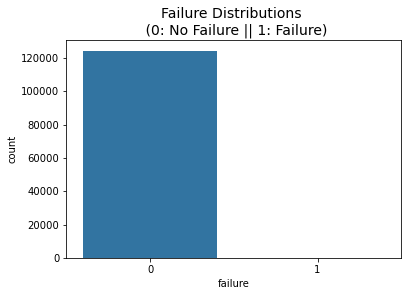

In [12]:
sns.countplot('failure', data = df)
plt.title('Failure Distributions \n (0: No Failure || 1: Failure)', fontsize=14)

In [13]:
# Split X and Y dataset
X = df.iloc[:, 1:]  
y = df.iloc[:, :1]

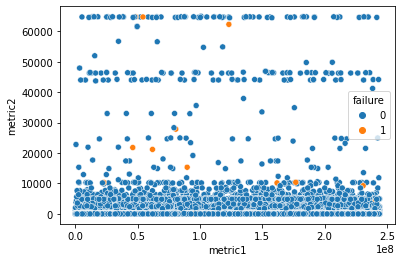

In [14]:
sns.scatterplot(X['metric1'], X['metric2'], hue = y['failure'])
plt.show();

In [15]:
# make statify = y for imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                              test_size = 0.2, stratify = y )
    
   

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(99595, 1177) (24899, 1177) (99595, 1) (24899, 1)


In [17]:
y_train.sum()

failure    85
dtype: int64

In [18]:
y_test.sum()

failure    21
dtype: int64

# Logistic Classification

In [19]:
# Logistic Classification with class_weight

weights = {0: 0.085, 1: 1} # failed ratio calculated above
clf_lr = LogisticRegression(class_weight= weights, max_iter = 1000)
clf_lr.fit(X_train, y_train)


LogisticRegression(class_weight={0: 0.085, 1: 1}, max_iter=1000)

In [20]:
pred_lr_tr = clf_lr.predict(X_train)
pred_lr_te = clf_lr.predict(X_test)

In [21]:
print('Train Accuracy Score - ',accuracy_score(pred_lr_tr, y_train))
print('Val Accuracy Score - ',accuracy_score(pred_lr_te, y_test))


Train Accuracy Score -  0.9988352828957276
Val Accuracy Score -  0.9987549700791196


tn, fp, fn, tp [[24868    21]
 [   10     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24889
           1       0.00      0.00      0.00        10

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899



Text(0.5, 15.0, 'Predicted')

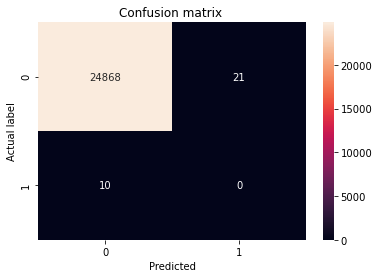

In [22]:
# confusion matrix on Test
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''


conf_matrix_lr_te = confusion_matrix(pred_lr_te , y_test )
print('tn, fp, fn, tp', confusion_matrix(pred_lr_te, y_test ))
# print(conf_matrix_lr_tr)

conf_matrix_lr_report_te = classification_report(pred_lr_te, y_test )
print(conf_matrix_lr_report_te)
sns.heatmap(conf_matrix_lr_te, annot=True, fmt = 'd')
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted')

In [23]:
# ROC for Train and Test

pred_lr_tr_proba = clf_lr.predict_proba(X_train)
pred_lr_tr_proba = pred_lr_tr_proba[:, 1] # taking only the last column
roc_acc_lr_tr = roc_auc_score(y_train, pred_lr_tr_proba)



pred_lr_te_proba = clf_lr.predict_proba(X_test)
pred_lr_te_proba = pred_lr_te_proba[:, 1] # taking only the last column
roc_acc_lr_te = roc_auc_score(y_test, pred_lr_te_proba)

print(f'ROC score for Train is {roc_acc_lr_tr}')
print(f'ROC score for Test is {roc_acc_lr_te}')

ROC score for Train is 0.5196754095065823
ROC score for Test is 0.443315761870308


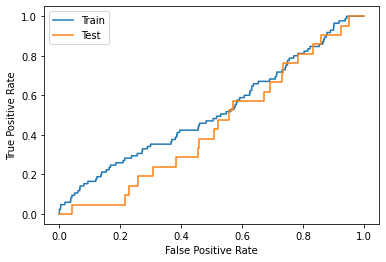

In [24]:
# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

lr_fpr_rf_tr, lr_tpr_rf_tr, _ = roc_curve(y_train, pred_lr_tr_proba)
lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, pred_lr_te_proba)
plt.plot(lr_fpr_rf_tr, lr_tpr_rf_tr, label = 'Train')
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# SMOTE

SMOTE or Synthetic Minority Oversampling Technique is a popular algorithm to creates sythetic observations of the minority class.

SVMSMOTE - Variance of SMOTE using SMOTE algorithm.

SMOTETomek combines undersampling and oversampling using Tomek link (Tomeck links remove unwanted pos and neg classes)

In [25]:
# Applying SMOTE to full dataset
sm = SMOTE()

X_sm, y_sm = sm.fit_sample(X,y)

y_sm['failure'].value_counts()

1    124388
0    124388
Name: failure, dtype: int64

In [26]:
# Applying SVSMOTE to full dataset
svm = SVMSMOTE()

X_svm, y_svm = svm.fit_sample(X,y)

y_svm['failure'].value_counts()

0    124388
1     49338
Name: failure, dtype: int64

In [27]:
# Applying SVSMOTETomek to full dataset
# sm_t = SMOTETomek()

# X_sm_t, y_sm_t = sm_t.fit_sample(X,y)

# y_sm_t['failure'].value_counts()

# Random Forest

In [28]:
# make statify = y for imbalanced dataset
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, 
                              test_size = 0.25 )
    
print(X_train_sm.shape, X_test_sm.shape, y_train_sm.shape, y_test_sm.shape) 

(186582, 1177) (62194, 1177) (186582, 1) (62194, 1)


In [29]:
type(X_train_sm)

pandas.core.frame.DataFrame

In [30]:
# Random Forest Model
clf_rf = RandomForestClassifier(max_depth= 5,random_state =42)

# fit the model
X_train_sm = X_train_sm.values
y_train_sm = y_train_sm.values.ravel()
clf_rf.fit(X_train_sm, y_train_sm)


RandomForestClassifier(max_depth=5, random_state=42)

In [31]:
# predict the result
y_pred_sm = clf_rf.predict(X_test_sm)

Feature  : 0 and Score = 0.1793185492071733
Feature  : 1 and Score = 0.1591865669144235
Feature  : 2 and Score = 0.12836475761455468
Feature  : 3 and Score = 0.06826054589327406
Feature  : 4 and Score = 0.045533787216475746
Feature  : 5 and Score = 0.04264977082304422
Feature  : 6 and Score = 0.037184201713266994
Feature  : 7 and Score = 0.015198007389011307
Feature  : 8 and Score = 0.011513571670636578
Feature  : 9 and Score = 0.010591316262390385


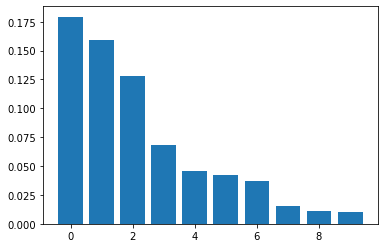

In [32]:
# plotting the feature importance

importance = sorted(clf_rf.feature_importances_, reverse = True)
top_list = importance[0:10]

for i,v in enumerate(top_list):
    print(f'Feature  : {i} and Score = {v}')

plt.bar([x for x in range(len(top_list))], top_list)
plt.show()

# print(top_10)

tn, fp, fn, tp [[24868    21]
 [   10     0]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     34031
           1       0.86      0.94      0.90     28163

    accuracy                           0.90     62194
   macro avg       0.90      0.91      0.90     62194
weighted avg       0.91      0.90      0.90     62194



Text(0.5, 15.0, 'Predicted')

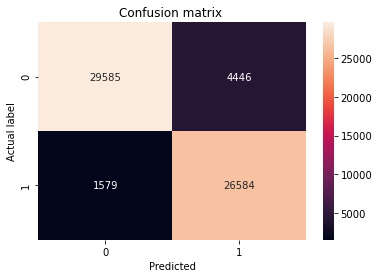

In [33]:
# confusion matrix on Test
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''


conf_matrix_rf_te = confusion_matrix(y_pred_sm , y_test_sm )
print('tn, fp, fn, tp', confusion_matrix(pred_lr_te, y_test ))
# print(conf_matrix_lr_tr)

conf_matrix_rf_report_te = classification_report(y_pred_sm, y_test_sm )
print(conf_matrix_rf_report_te)
sns.heatmap(conf_matrix_rf_te, annot=True, fmt = 'd')
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted')

In [34]:

scoring = ['neg_log_loss', 'accuracy', 'roc_auc', 'precision', 'recall']


scores_tr = cross_validate(clf_rf, X_train_sm, y_train_sm,scoring = scoring,
                          cv =5, n_jobs = -1)

# print results
print(' ROC AUC :',scores_tr)
print('Train neg log is ',scores_tr['test_neg_log_loss'])
print('Train accuracy is ',scores_tr['test_accuracy'])
print('Train precision is ',scores_tr['test_precision'])
print('Train recall is ',scores_tr['test_recall'])
print('Train ROC is ',scores_tr['test_roc_auc'])


 ROC AUC : {'fit_time': array([100.22269297, 100.94316411,  99.93087578,  99.98222399,
        97.97030687]), 'score_time': array([1.72531509, 1.59478092, 1.82572007, 1.819206  , 2.03401804]), 'test_neg_log_loss': array([-0.4991212 , -0.52064482, -0.51565477, -0.51930578, -0.52060159]), 'test_accuracy': array([0.90736126, 0.9069057 , 0.90446457, 0.904009  , 0.90127559]), 'test_roc_auc': array([0.9674722 , 0.96975673, 0.97179232, 0.96666178, 0.96697312]), 'test_precision': array([0.95919599, 0.95113987, 0.96314692, 0.93567015, 0.93322928]), 'test_recall': array([0.85106041, 0.85802271, 0.84125114, 0.8678164 , 0.86455656])}
Train neg log is  [-0.4991212  -0.52064482 -0.51565477 -0.51930578 -0.52060159]
Train accuracy is  [0.90736126 0.9069057  0.90446457 0.904009   0.90127559]
Train precision is  [0.95919599 0.95113987 0.96314692 0.93567015 0.93322928]
Train recall is  [0.85106041 0.85802271 0.84125114 0.8678164  0.86455656]
Train ROC is  [0.9674722  0.96975673 0.97179232 0.96666178 0.96

In [35]:
# ROC caculation
pred_rf_tr_proba = clf_rf.predict_proba(X_train_sm)
pred_rf_te_proba = clf_rf.predict_proba(X_test_sm)

pred_rf_tr_proba[0:10]
pred_rf_te_proba[0:10]


#only the second column is needed
pred_rf_tr_proba_1 = [p[1] for p in pred_rf_tr_proba]
pred_rf_te_proba_1 = [p[1] for p in pred_rf_te_proba]


roc_acc_rf_tr = roc_auc_score( y_train_sm, pred_rf_tr_proba_1)
roc_acc_rf_te = roc_auc_score( y_test_sm, pred_rf_te_proba_1)
print('Train ROC score is ', roc_acc_rf_tr)
print('Test ROC score is ', roc_acc_rf_te)

Train ROC score is  0.96985136578274
Test ROC score is  0.9676620458470452


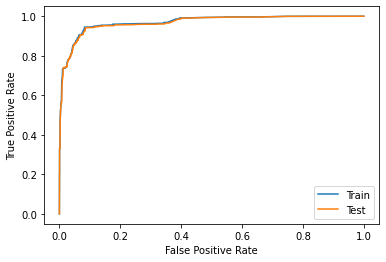

In [36]:
# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

lr_fpr_rf_tr, lr_tpr_rf_tr, _ = roc_curve(y_train_sm, pred_rf_tr_proba_1)
lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test_sm, pred_rf_te_proba_1)
plt.plot(lr_fpr_rf_tr, lr_tpr_rf_tr, label = 'Train')
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()